# Objective.

For the experimental situation, measurement of the two-photon absorption coefficient for CdSe using the f-scan technique is analyzed for reliability in terms of the new distribution.

In [2]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy import stats
import pandas as pd
import sympy as sym
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
import seaborn as sns
import os
from scipy.stats import anderson
from scipy.stats import kstest
from scipy.stats import shapiro 
#to en otra carpeta


In [3]:
# Función ajustar
def fscanTH2(focal,beta,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    B = beta*(1.0 - R)*I0*Leff
    # Transmitance
    T=1-1/(2*np.sqrt(2))*beta*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2)
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return T

# Función ajustar
def BETA(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):

    Leff = (1. - np.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(np.pi*D) # beam waist
    z0 = np.pi*w0**2/wl # Rayleigh range
    w = w0*np.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*np.sqrt(np.log(2))*Pavg/(Tp*freq*np.pi**1.5*w**2) # Peak intensity at sample
    # Transmitance
    b=(1-trans)*(1/(2*np.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    #T = [sum((-B[i])**m/(m + 1.0)*p(m) for m in range(0,N))
        ##  for i in range(len(B))]
    return b


def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], señal[i]*desv) for i in range(0,len(señal))]
    return np.array(señal_ruido)

def central(s,k):

    '''
    Funcion para verificar teorema del limite central

    Parametros
    -----------
    s: Arreglo
     Arreglo de datos a los que se quieren aplicar el teorema
    k: float
     Numero de datos para efectuar el promedio

'''

    new_s=[]

    for i in range(0,len(s)):
        new_s.append(np.mean(np.random.choice(s,size=k)))
    return new_s

def confirm_gauss(s):
    result = (anderson(np.sort(s), dist='norm'))
    criterio=((result[0]<result[1][3])or(shapiro(np.sort(s))[1]>0.05))*1   
    return criterio
    


# Experimental data.

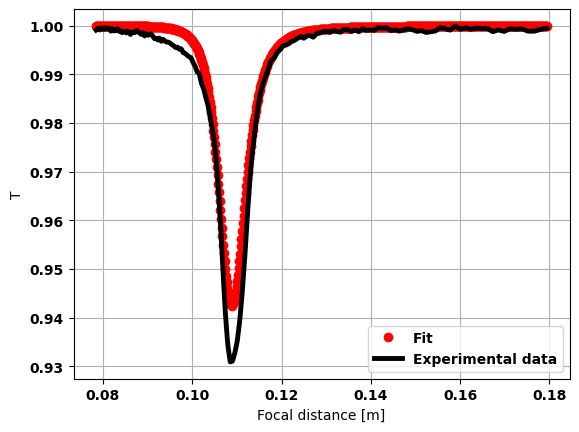

In [4]:
# Datos reportados:
L= 0.79e-3 # thickness in (m).
Pavg = 145e-3# Average power in (W)
Tp = 71e-15 # pulse width FWHM in (s)
wl =790e-9 #central wavelength in (m)
D = 2e-3 # beam diameter in (m)
ds = 109.0e-3# Distance EFTL-sample (m)a
Cf = 1.36 # beam correction coeff
alfa = 369 # linear absorption in (1/m) 
R =0.185 # reflection percentage 
freq = 90.6e6#Frecuencia en HZ

datos=np.loadtxt('CdSe-data-corr-TFscan-FIT.txt')
focal=datos[:,0]
T_e=list(datos[:,1])
index=T_e.index(min(T_e))
T_a=datos[:,2]

t_t= fscanTH2(focal,3e-11,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)

#plt.plot(focal,T_a,'ro',label='fitting data')
plt.plot(focal,t_t,'ro',label='Fit')
plt.plot(focal,T_e,'k',label='Experimental data',linewidth=3.5)
plt.legend()
plt.xlabel('Focal distance [m]')
plt.ylabel('T')
plt.grid()

In [5]:
def dist_betas(N,par,desv): 
    '''
    Parametros
    ----------
    N: float
        Numero de valores con los que se va a formar el histograma
    desv: float
        Arreglo con distancias focales utilizadas.
    k: float
        indice del arreglo de la distancia focal.
    par: array
        arreglo de 0 o 1 dependiendo de cual parametro se quiera investigar.
        [L,P,T,wl,D,ds,Cf,alpha,R,freq,trans,focal]

    La función devuelve la distribucion de beta
    '''
  # Cont,edra valores de TPA
    TPA=[]
    trans=T_e[index] #Minimo de la señal simulada. 
    f=focal[index]  #Distancia focal correspondiente al minimo.   
    er_L=0.01e-3*par[0]
    er_P=5e-3*par[1]
    er_T=0.3e-15*par[2]
    er_wl=1e-9*par[3]
    er_D=desv*par[4]
    er_ds=0.5e-3*par[5]
    er_Cf=0.04*par[6]
    er_a=37*par[7]
    er_R=0.005*par[8]
    er_freq=0*par[9]
    er_trans=0*par[10]
    er_focal=0.5e-3*par[11]
    # Randomly c
    for ii in range(N):


        L_f = np.random.normal(L,er_L,1) # # thickness in (m).
        Pavg_f = np.random.normal(Pavg,er_P,1) # Average power in (W)
        Tp_f = abs(np.random.normal(Tp,er_T,1)) # Pulse width FWHM in (s). sech
        wl_f = np.random.normal(wl,er_wl,1) #central wavelength in (m)
        D_f = np.random.normal(D,er_D,1) # beam diameter in (m)
        ds_f = np.random.normal(ds,er_ds,1) # EFTL-sample distance (m)
        Cf_f = np.random.normal(Cf,er_Cf,1) # Beam correction factor
        alfa_f =  abs(np.random.normal(alfa,er_a,1)) #linear absorption (1/m)
        R_f = np.random.normal(R,er_R,1) # Reflectance
        freq_f = np.random.normal(freq,er_freq,1) # Reflectance
        trans_f= np.random.normal(trans,er_trans,1)
        focal_f=np.random.normal(f,er_focal,1) 
        TPA.append(BETA(trans_f,focal_f,L_f,Pavg_f,Tp_f,wl_f,D_f,ds_f,Cf_f,alfa_f,R_f,freq_f)[0])
      
    
    return TPA




In [6]:
L_s, P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,T_s,f_s = sym.symbols('L P Tp wl D ds Cf alpha R v T f')
params_s=[L_s, P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,T_s,f_s]

# Función ajustar
def BETA_S(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq):


    Leff = (1. - sym.exp(-alfa*L))/alfa # Effective thickness
    w0 = 2.0*wl*focal*Cf/(sym.pi*D) # beam waist
    z0 = sym.pi*w0**2/wl # Rayleigh range
    w = w0*sym.sqrt(1 + ((ds - focal)/z0)**2) # Beam radius
    I0 = 4*sym.sqrt(sym.log(2))*Pavg/(Tp*freq*sym.pi**1.5*w**2) # Peak intensity at sample
    b=(1-trans)*(1/(2*sym.sqrt(2))*(1-R)*I0*Leff/(1+((ds-focal)/z0)**2))**-1
    return b

def BETA_prime(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq,param,n):
    return sym.diff(BETA_S(trans,focal,L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq),param,n)


def gaussian(x,mu,sigma):
    return 1/np.sqrt(np.pi*2*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

i=4
DerivativeOfF= sym.lambdify((T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s),BETA_prime(T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,params_s[i],1),"numpy")
DerivativeOfF2= sym.lambdify((T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s),BETA_prime(T_s, f_s,L_s,P_s,Tp_s,wl_s,D_s,ds_s,Cf_s,alfa_s,R_s,v_s,params_s[i],2),"numpy")
c1=DerivativeOfF(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)
c2=DerivativeOfF2(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)/2

def real(x,sigma):
    
    k1=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)-c1**2/(4*c2)
    mu0=c1/(2*np.sqrt(c2))
    sigm0=np.sqrt(c2*sigma**2)
    x_new=np.sqrt((x-k1))
    return 1/(2*x_new)*(gaussian(x_new,mu0,sigm0)+gaussian(-x_new,mu0,sigm0))

/tmp/ipykernel_3886/1501023215.py:34: RuntimeWarning: invalid value encountered in sqrt
  x_new=np.sqrt((x-k1))


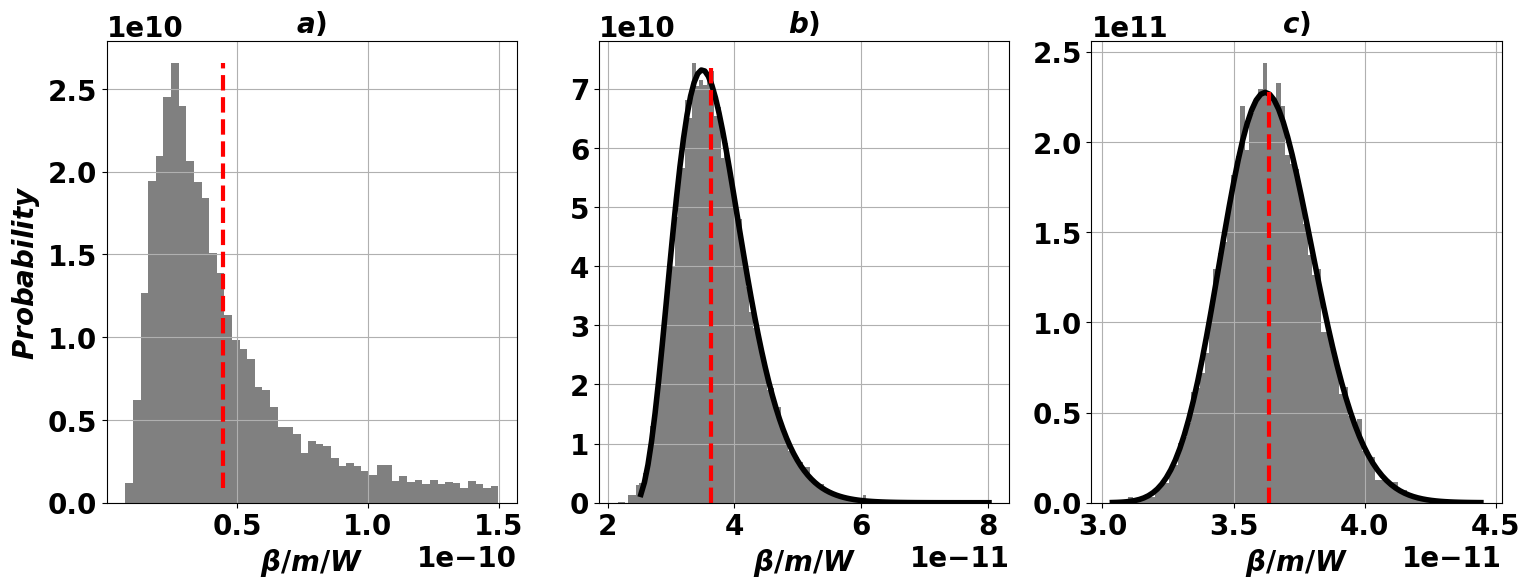

In [41]:
meansc=[]
desvg=[]
desvc=[]
meanscal=[]
desvcal=[]

f=plt.figure(figsize=(18,6))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

plt.subplot(131)
pars=np.ones(12)
beta_hist=np.array(dist_betas(10000,pars,0.8e-3))
borr=[]
for i in range(len(beta_hist)):
    if beta_hist[i]>15e-11:
        borr.append(i)

beta_hist=np.delete(beta_hist,borr)
err=0.8
n1, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
plt.ylabel('$Probability$',fontsize=20)
plt.xlabel(r'$\beta/m/W$',fontsize=20)
plt.title('$a)$',fontsize=20)
mids1 = 0.5*(bins[1:] + bins[:-1])
meansc.append(np.average(mids1, weights=n1))
mean=np.average(mids1, weights=n1)
plt.vlines(mean,ymin=min(n1),ymax=max(n1),color='r',linewidth=3,linestyle='--')
var = np.average((mids1 - mean)**2, weights=n1)
desvc.append(var**0.5)
plt.grid(True)


plt.subplot(132)
pars=np.zeros(12)
pars[4]=1
err=0.16e-3
beta_hist=np.array(dist_betas(20000,pars,err))
borr=[]
for i in range(len(beta_hist)):
    if beta_hist[i]>10e-11:
        borr.append(i)

beta_hist=np.delete(beta_hist,borr)
#print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
mids2 = 0.5*(bins[1:] + bins[:-1])
func2=real(mids2,err)
plt.plot(mids2,func2,'k',linewidth=4)
plt.title('$b)$',fontsize=20)
plt.vlines((BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2**2*err**2),ymin=min(n),ymax=max(n),linewidth=3,color='r',linestyle='--')
meansc.append(np.average(mids2, weights=n))
mean=np.average(mids2, weights=n)
var = np.average((mids2 - mean)**2, weights=n)
desvc.append(var**0.5)
meanscal.append(BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2**2*err**2)
desvcal.append(np.sqrt(c1**2*err**2+2*c2**4*err**4))
plt.grid()
plt.xlabel(r'$\beta/m/W$',fontsize=20)


plt.subplot(133)
pars=np.zeros(12)
pars[4]=1
err=0.05e-3
beta_hist=np.array(dist_betas(20000,pars,err))
borr=[]
for i in range(len(beta_hist)):
    if beta_hist[i]>8e-11:
        borr.append(i)

beta_hist=np.delete(beta_hist,borr)
#mu, sigma) = norm.fit(beta_hist)
#l = plt.plot(bins, y, '--k', linewidth=4)
err=0.05e-3
##print('Criterio de gaussianidad: ',confirm_gauss(beta_hist))
#(mu, sigma) = norm.fit(beta_hist)
n, bins, patches =plt.hist(beta_hist,bins='fd',density=True,color='gray')
#y = norm.pdf( bins, mu, sigma)
#l = plt.plot(bins, y, '--k', linewidth=4)
#u=BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2*err**2
#sigma=np.sqrt(err-3**2*c1**2+c2**2*(3**err-3**4-err-3**2))
plt.grid(True)
plt.title('$c)$',fontsize=20)
plt.xlabel(r'$\beta/m/W$',fontsize=20)
mids = 0.5*(bins[1:] + bins[:-1])
func=real(mids,err)
plt.plot(mids,func,'k',linewidth=4)
meansc.append(np.average(mids, weights=n))
mean=np.average(mids, weights=n)
desvg.append(np.std(beta_hist))
var = np.average((mids - mean)**2, weights=n)
desvc.append(var**0.5)
meanscal.append(BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2**2*err**2)
desvcal.append(np.sqrt(c1**2*err**2+2*c2**4*err**4))
plt.vlines((BETA(T_e[index],focal[index],L,Pavg,Tp,wl,D,ds,Cf,alfa,R,freq)+c2**2*err**2),ymin=min(func),ymax=max(func),color='r',linewidth=3,linestyle='--')



# Confidence interval.

 # a)

In [53]:
new_int=[]

for i in range(len(mids1)):
    if mids1[i]>(meansc[0]-desvc[0]) and mids1[i]<(meansc[0]+desvc[0]):
        new_int.append(i)

new_mids=mids1[new_int[0]:new_int[-1]]
new_func=n1[new_int[0]:new_int[-1]]
print(np.trapz(new_func,new_mids))

0.9281841319021799


In [31]:
meansc[0], desvc[0]

(4.456286605494014e-11, 2.8804822280899823e-11)

# b)

In [54]:
new_int=[]
for i in range(len(mids2)):
    if mids2[i]>(meanscal[0]-desvcal[0]) and mids2[i]<(meanscal[0]+desvcal[0]):
        new_int.append(i)


new_mids=mids2[new_int[0]:new_int[-1]]
new_func=func2[new_int[0]:new_int[-1]]
print(np.trapz(new_func,new_mids))

0.9359900687962658


In [50]:
meanscal[0],desvcal[0]

(3.633831886724754e-11, 5.626693748675709e-12)

# c)

In [55]:
new_int=[]
for i in range(len(mids)):
    if mids[i]>(meanscal[1]-desvcal[1]) and mids[i]<(meanscal[1]+desvcal[1]):
        new_int.append(i)


new_mids=mids[new_int[0]:new_int[-1]]
new_func=func[new_int[0]:new_int[-1]]
print(np.trapz(new_func,new_mids))

0.9420840739281665


In [52]:
meanscal[1], desvcal[1]

(3.63383020643744e-11, 1.7583417964437813e-12)

In [40]:
meanscal

[3.63383020643744e-11]

In [84]:
meansc

[4.390439139076815e-11, 3.732772945940833e-11, 3.659278243138138e-11]

In [85]:
meanscal

[5.018724480691416e-10, 3.6338765780029455e-11, 3.6338307519852686e-11]